In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib import colors
from scipy import stats

# --------------- IMPORTING THE DATA --------------- #

# Evacuation Data
evacdata = pd.read_csv('./output_new_new/walking_dis/gy-evac walking-table.csv', skiprows=6).sort_values(by=['terminate-evac-distance-km', 'ticks']).reset_index(drop=True)
# renaming the column to something that isn't cursed
evacdata.rename(columns={'[run number]': 'run_number'}, inplace=True)
evacdata.rename(columns={'initial-people': 'population'}, inplace=True)
evacdata.rename(columns={'max-walking-distance-km': 'walk_dist'}, inplace=True)
evacdata.columns = evacdata.columns.str.replace('-', '_')
# calculate time in minutes
evacdata['time_minutes'] = evacdata['ticks'] * evacdata['tick_time_in_mins']
evacdata['warning_interval_time_mins-1'] = (evacdata['warning_interval_time_mins'] / 60) -0.5
evacdata['evacuated_perc'] = evacdata['get_no_evacuated'] / evacdata['population'] * 100
evacdata['evacuating_perc'] = evacdata['get_no_evacuating'] / evacdata['population'] * 100

# Journey Time Data
jm_files = glob.glob('./output_new_new/walking_dis/jm*.csv')
journey_metrics_list = [pd.read_csv(file) for file in jm_files]
# Extract tick number from file names and add as a column to each dataframe
for i, file in enumerate(jm_files):
    tick_number = int(file.split('/')[-1].split('_')[7][1])
    journey_metrics_list[i]['walk_dist'] = tick_number
# Concatenate the dataframes
journey_metrics = pd.concat(journey_metrics_list, ignore_index=True).sort_values(by=['walk_dist', 'start_tick']).reset_index(drop=True)
# calculate time in minutes
journey_metrics['start_time_minutes'] = journey_metrics['start_tick'] * 0.3 # 0.3 minutes per tick

# calculate normalised journey time
journey_metrics['normalised_journey_time'] = journey_metrics['actual_time'] / journey_metrics['ideal_time']

# calculate the mean normalised journey time every 30 minutes for each run
# Bin the start_tick at intervals of 120 (corresponding to 30 minutes)
journey_metrics['start_time_bin'] = pd.cut(journey_metrics['start_time_minutes'], bins=np.arange(-15, journey_metrics['start_tick'].max() + 45, 30))
# Calculate the mean normalised journey time for each bin
mean_normalised_journey_time_per_bin = journey_metrics.groupby('start_time_bin')['normalised_journey_time'].mean().reset_index()
# Calculate the mean normalised journey time for each bin for each run
mean_normalised_journey_time_per_bin_per_run = journey_metrics.groupby(['walk_dist', 'start_time_bin'])['normalised_journey_time'].mean().reset_index()

In [7]:
journey_metrics.tail()

,car_id,passengers,ideal_time,actual_time,start_tick,end_tick,walk_dist,start_time_minutes,normalised_journey_time,start_time_bin
19079,26417,2,0.054615,360.0,1099,1111,5,329.7,6591.646004,"(315, 345]"
19080,7133,1,0.053490,420.0,1199,1213,5,359.7,7851.996105,"(345, 375]"
19081,12240,2,0.058500,450.0,1199,1214,5,359.7,7692.307692,"(345, 375]"
19082,4846,1,0.054615,360.0,1399,1411,5,419.7,6591.646004,"(405, 435]"
19083,32701,1,0.053490,360.0,1499,1511,5,449.7,6730.282376,"(435, 465]"


In [14]:
evacdata.walk_dist.unique()

array([4, 1, 5, 2, 3, 7, 6, 0])

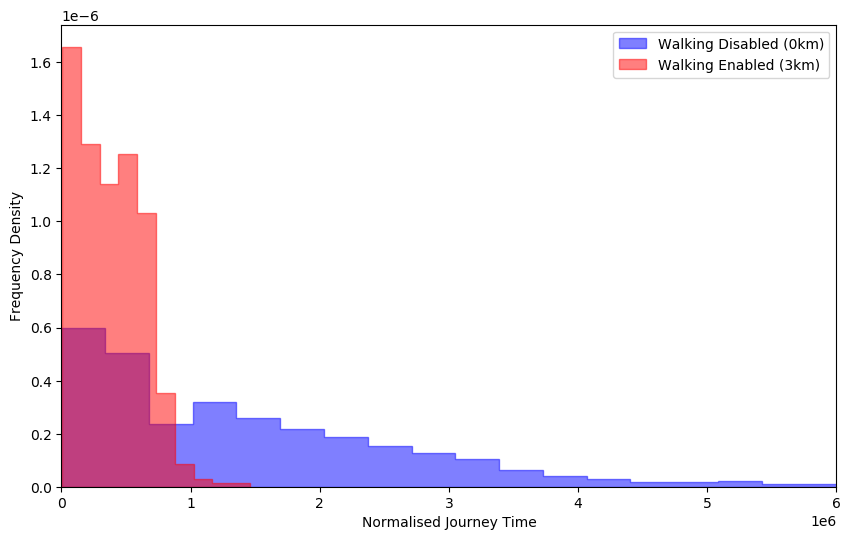

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.hist(journey_metrics[journey_metrics['walk_dist'] == 0]['normalised_journey_time'],  histtype = 'stepfilled', bins=40, color='b', edgecolor='b', alpha=0.5, density=True, label = 'Walking Disabled (0km)')
plt.hist(journey_metrics[journey_metrics['walk_dist'] == 3]['normalised_journey_time'], bins=10, histtype = 'stepfilled',color = 'r',  edgecolor='r', alpha=0.5, density=True, label = 'Walking Enabled (3km)')
#plt.xscale('log')
plt.xlim(0, 0.6e7)

ax.set_xlabel('Normalised Journey Time')
ax.set_ylabel('Frequency Density')
plt.legend()

ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))